In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
os.environ["GOOGLE_CSE_ID"] = os.getenv("GOOGLE_CSE_ID")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv("OPENWEATHERMAP_API_KEY")
alphavantage_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")


In [2]:
from typing_extensions import TypedDict, Annotated

from langchain.chat_models import init_chat_model
from langchain.tools import Tool
from langchain_community.tools import tool
from langchain_core.messages import HumanMessage, AnyMessage

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain_experimental.tools.python.tool import PythonREPLTool 


from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from IPython.display import Image, display

In [3]:
llm = init_chat_model("gpt-4.1", temperature=0.7)

In [4]:
serper_tool = Tool(
    name="serper",
    description="Search news, events, or facts using Serper-powered web search.",
    func=GoogleSerperAPIWrapper().run,
)

google_search_tool = Tool(
    name="google_search",
    description="Search for restaurants or places with Google Search.",
    func=GoogleSearchAPIWrapper().run,
)

weather_tool = Tool(
    name="openweathermap",
    description="Fetch current weather for any city.",
    func=OpenWeatherMapAPIWrapper().run,
)

alpha_vantage_api = AlphaVantageAPIWrapper(alphavantage_api_key=alphavantage_api_key)

@tool
def currency_tool(from_currency: str, to_currency: str) -> str:
    """Get exchange rate between two currencies."""
    return alpha_vantage_api.run(from_currency=from_currency, to_currency=to_currency)

repl_tool = PythonREPLTool()

tools = [serper_tool, google_search_tool, weather_tool, currency_tool, repl_tool]

In [5]:
# Create the list of properly wrapped Tool instances
tools = [serper_tool, google_search_tool, weather_tool, currency_tool, repl_tool]

In [6]:
react_prompt = """
You are a helpful and intelligent Travel Planner agent. Your role is to assist users in planning trips by:

- Providing accurate **weather forecasts** for cities.
- Giving **real-time currency exchange rates** between two currencies.
- Suggesting **popular events and attractions** at the destination.
- Recommending **hotels and restaurants** based on location and query.

You have access to various tools to help gather information.

Use the format below to reason through your answer:

Thought: You think about what to do next  
Action: The action you take, using one of the tools  
Action Input: The input to the action  
Observation: The result of the action

Repeat **[Thought → Action → Observation]** as needed.

**When you have enough information, respond with:**  
Final Answer: <your summarized travel advice>

**Do NOT call any tools after you provide the Final Answer.**
"""


In [7]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [8]:
def reasoning_node(state: State):
    # LLM with bound tools to enable tool-calling
    llm_with_tools = llm.bind_tools(tools)
    messages = [{"role": "system", "content": react_prompt}] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": state["messages"] + [response]}

In [9]:
tool_node = ToolNode(tools = tools)

In [10]:
def should_continue(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "content") and "final answer:" in last_message.content.lower():
        return "end"
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"
    if len(state["messages"]) > 20:
        return "end"
    # Otherwise, no tool_calls, not a final answer, so end gracefully
    return "end"

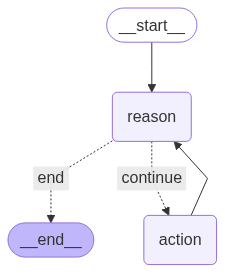

In [11]:
builder = StateGraph(State)
builder.add_node("reason", reasoning_node)
builder.add_node("action", tool_node)
builder.set_entry_point("reason")
builder.add_conditional_edges(
    "reason",
    should_continue,
    {
        "continue": "action",
        "end": END,
    }
)
builder.add_edge("action", "reason")
agent = builder.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [12]:
query = ("""
         We’re planning a Tokyo trip in March. 
         What’s the typical weather.
         How much is 100,000 indian rupee in yen now. 
         List two popular events and nearby vegan restaurants.
         """)

state = {"messages": [HumanMessage(content=query)]}
result = agent.invoke(state)

print(result["messages"][-1].content)


Final Answer: 
Here’s a summary for your Tokyo trip planning in March:

- Typical Weather: March in Tokyo is generally cool and pleasant, transitioning from winter to spring. Expect average highs around 13°C (55°F) and lows near 5°C (41°F). Occasional rain is possible, and cherry blossoms may begin blooming late in the month.

- Currency Exchange: 100,000 Indian Rupees is currently about 169,790 Japanese Yen (based on today’s exchange rate of 1 INR ≈ 1.70 JPY).

- Popular Events in March:
  1. Plum Blossom Festival at Jindai Botanical Gardens.
  2. Tokyo Marathon (usually early March), plus the start of cherry blossom season and related festivals.

- Nearby Vegan Restaurants:
  1. T’s Tantan (vegan ramen, Tokyo Station area)
  2. Ain Soph. Ginza (creative vegan dining, Ginza area)

Let me know if you want hotel recommendations or more details on events!


In [13]:
query = ("Hi")

state = {"messages": [HumanMessage(content=query)]}
result = agent.invoke(state)

print(result["messages"][-1].content)


Hello! How can I assist you with your travel plans today?
